# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2024/homeworks/hw4_recsys/music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2024/homeworks/hw4_recsys/tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def apk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in relevant and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not relevant:
        return 0.0

    apk = score / min(len(relevant), k)
    return apk

In [6]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    return np.mean([apk(a,p,k) for a,p in zip(relevant, predicted)])

In [7]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [8]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [9]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [10]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [11]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [12]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [13]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [14]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [15]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [16]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        users = np.array(self.ratings['userId'].unique())
        recommendations = np.array(list(map(self.recommend, users)))
        test_preds = self.remove_train_items(recommendations, k)
        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [17]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    return np.dot(ratings, user_vector) / np.sqrt(np.sum(ratings, axis=1) * np.sum(user_vector))


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    intersection = np.dot(ratings, user_vector)
    return intersection / (np.sum(ratings, axis=1) + np.sum(user_vector) - intersection)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [18]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def filter_users(self, users_sim: np.array):
        chosen_id = []
        chosen_sim = []
        for i in range(self.n_users):
            if users_sim[i] > self.alpha:
                chosen_id.append(i)
                chosen_sim.append(users_sim[i])

        return np.array(chosen_id), np.array(chosen_sim)

    def calc_r(self, track_raitings: np.array, users_sim: np.array):
        sim_sum = np.sum(users_sim)
        return np.dot(track_raitings, users_sim) / sim_sum



    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        users_similarity = self.similarity(self.R[uid])
        users_similarity[uid] = 0.0  # здесь занулим схожесть с самим собой, чтобы не учитывать при рекомендациях

        filtered_users_id, filtered_users_sim = self.filter_users(users_similarity)
        filtered_users_id = np.array(filtered_users_id, dtype=int)
        filtered_raitings = self.R[filtered_users_id, :]

        tracks = np.array(list(enumerate(np.apply_along_axis(lambda col: self.calc_r(col, filtered_users_sim), 0, filtered_raitings))))
        return tracks[tracks[:, 1].argsort()][:,0][::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [19]:
results_pearson = []
results_jaccard = []

k_values = [6, 12, 18, 24]

model_1 = User2User(train_ratings, pearson)
model_2 = User2User(train_ratings, jaccard)

for k in k_values:
    preds_p = model_1.get_test_recommendations(k)
    preds_j = model_2.get_test_recommendations(k)
    results_pearson.append(mapk(test_relevant, preds_p, k))
    results_jaccard.append(mapk(test_relevant, preds_j, k))

<ipython-input-18-c80f6d877521>:22: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(track_raitings, users_sim) / sim_sum


In [20]:
train_ratings['trackId'].unique().shape

(67313,)

In [21]:
results_random = []
for k in k_values:
    rng = np.random.default_rng(12345)
    preds_r = np.array([rng.integers(low=0, high=67313, size=k) for _ in range(235)])
    results_random.append(mapk(test_relevant, preds_r, k))

In [22]:
results_jaccard, results_pearson, results_random

([0.0011229314420803781,
  0.001117059654293697,
  0.0008554930676332428,
  0.0008207404753358935],
 [0.0009692671394799053,
  0.0008539037794356944,
  0.0007382036449620932,
  0.0006894434797538076],
 [0.00011820330969267139,
  3.223726627981947e-05,
  7.300792657488526e-05,
  3.445004354858778e-05])

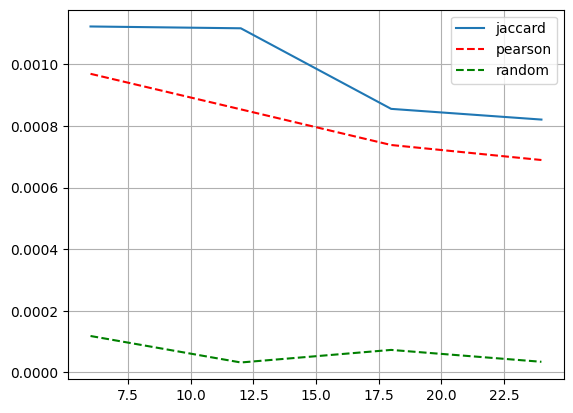

In [23]:
x = k_values
y1 = results_jaccard
y2 = results_pearson
y3 = results_random

fig, ax = plt.subplots()
ax.plot(x, y1, label='jaccard')
ax.plot(x, y2, 'r--', label='pearson')
ax.plot(x, y3, 'g--', label='random')
ax.grid(True)
ax.legend(loc="upper right")
plt.show()

In [24]:
# Пусть качество и не очень высокое, но видно, что это точно лучше, чем просто рандомное предсказывание
# При этом использование jaccard показало качество чуть повыше

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [25]:
def pearson_sparse(ratings: scs.csc_matrix, user_vector: scs.csc_matrix) -> scs.csc_matrix:
    numerator = ratings.dot(user_vector.T)
    denominator = ratings.sum(axis=1) * user_vector.sum()
    denominator.data = np.sqrt(denominator.data)
    return scs.csc_matrix(numerator / denominator)

def jaccard_sparse(ratings: scs.csc_matrix, user_vector: scs.csc_matrix) -> scs.csc_matrix:
    intersection = ratings.dot(user_vector.T)
    return scs.csc_matrix(intersection / (ratings.sum(axis=1) + user_vector.sum() - intersection))

In [26]:
class BaseModelSparse:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.R_sparse = scs.csc_matrix(self.R)

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        users = np.array(self.ratings['userId'].unique())
        recommendations = np.array(list(map(self.recommend, users)))
        test_preds = self.remove_train_items(recommendations, k)
        return test_preds[test_users]

In [29]:
class User2UserSparse(BaseModelSparse):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson_sparse, jaccard_sparse]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def filter_users(self, users_sim: scs.csc_matrix):
        chosen_id = []
        chosen_sim = []
        indexes = users_sim.indices
        data = users_sim.data
        for i in range(len(indexes)):
            if data[i] > self.alpha:
                chosen_id.append(indexes[i])
                chosen_sim.append(data[i])

        return np.array(chosen_id), np.array(chosen_sim)

    def similarity(self, user_vector: scs.csc_matrix):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R_sparse, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        users_similarity = self.similarity(self.R_sparse[uid])

        filtered_users_id, filtered_users_sim = self.filter_users(users_similarity)
        filtered_users_id = np.array(filtered_users_id, dtype=int)
        filtered_raitings = self.R_sparse[filtered_users_id, :]
        track_rates = filtered_raitings.T.dot(filtered_users_sim.T) / filtered_users_sim.sum()
        tracks = np.array(list(enumerate(track_rates)))
        return tracks[tracks[:, 1].argsort()][:,0][::-1]

In [27]:
import time

start = time.time()
model_1 = User2User(train_ratings, pearson)
model_2 = User2User(train_ratings, jaccard)

model_1.get_test_recommendations(5)
model_2.get_test_recommendations(5)
end = time.time()
print(f"Время выполнения: {end - start:.2f} сек")

<ipython-input-18-c80f6d877521>:22: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(track_raitings, users_sim) / sim_sum


Время выполнения: 308.20 сек


In [30]:
import time

start = time.time()
model_11 = User2UserSparse(train_ratings, pearson_sparse)
model_22 = User2UserSparse(train_ratings, jaccard_sparse)

preds_p1 = model_11.get_test_recommendations(5)
preds_j1 = model_22.get_test_recommendations(5)
print(mapk(test_relevant, preds_p1, 5))
print(mapk(test_relevant, preds_j1, 5))
end = time.time()
print(f"Время выполнения: {end - start:.2f} сек")

<ipython-input-25-77965fa381d0>:4: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  denominator.data = np.sqrt(denominator.data)


0.001021276595744681
0.000921985815602837
Время выполнения: 23.00 сек


In [31]:
# Видим, что при работе с разреженными матрицами все ускоряется больше чем в 10 раз

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [32]:
user_id = np.random.randint(0, model_11.n_users)

In [33]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
234,Wind Of Change,['Scorpions']
760,Wonderful Life,['Black']
886,In The Army Now,['Status Quo']
1019,It's My Life,['Bon Jovi']
1131,The Unforgiven,['Metallica']
2110,Москва,['Монгол Шуудан']
2500,Looking for the Summer,['Chris Rea']
2501,The Road To Hell. Part 2,['Chris Rea']
3961,Sadeness - Part I,['Enigma']
5214,Belladonna,['UFO']


In [34]:
preds = model_11.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-25-77965fa381d0>:4: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  denominator.data = np.sqrt(denominator.data)


Predicted tracks:


,name,artists
5653,Мой рок-н-ролл,['Би-2']
805,Zombie,['The Cranberries']
1056,Don't Speak,['No Doubt']
5872,Я свободен,['Кипелов']
1137,Nothing Else Matters,['Metallica']
9694,We Will Rock You,['Queen']
23944,Трасса Е-95,['Алиса']
4032,Bring Me To Life,['Evanescence']
11702,А что нам надо,['СерьГа']
2814,Numb,['Linkin Park']


In [35]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
64984,Someone,"['Vanotek', 'Denitia']"
64995,Insatiable Sax,['ladynsax']
65198,Не дано,"['Astero', 'Сергей Арутюнов']"
65209,нас не догонят,['Liam Howard']
65794,Throwback,['Michael Patrick Kelly']
65872,Город слепых,['7Б']
65956,Dance of the Clouds,['Origen']
66108,Feel Only Love,"['Klaas', 'Mister Ruiz']"
66195,"Amore Море, Goodbye","['Filatov & Karas', 'Мумий Тролль']"
66200,Heard About Me,"['Dimitri Vegas & Like Mike', 'Felix Jaehn', '..."


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Ответ

\\
**ALS:**

Ответ



**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [38]:
from numpy.random.mtrand import randint
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def calc_grad(self, p: np.ndarray, r: np.ndarray, q: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента
        """
        return 2 * p.T.dot(p.dot(q) - r) / p.shape[0] # Градиент для mse

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                for _ in tqdm(range(1000000)):
                    user = randint(0, self.n_users)
                    item = randint(0, self.n_items)
                    new_user = self.P[user] - self.lr * self.Q[item] * self.calc_grad(self.P[user], self.R[user, item], self.Q[item])
                    new_item = self.Q[item] - self.lr * self.P[user] * self.calc_grad(self.P[user], self.R[user, item], self.Q[item])
                    self.P[user] = new_user
                    self.Q[item] = new_item

                print(np.sum((self.P.dot(self.Q.T) - self.R) ** 2) / self.P.shape[0])

            elif self.mode == 'als':
                for i in tqdm(range(self.n_users)):
                    matrix = np.zeros((self.dim, self.dim))
                    vec = np.zeros(self.dim)
                    for j in range(self.n_items):
                        if self.R[i, j] == 1:
                            matrix += self.Q[j].T.dot(self.Q[j])
                            vec += self.Q[j]

                    print(matrix)
                    inversed = np.linalg.inv(matrix)
                    self.P[i] = inversed.dot(vec.T)

                for i in tqdm(range(self.n_items)):        # Здесь проходимся по айтемам и фиксируем юзеров
                    matrix = np.zeros((self.dim, self.dim))
                    vec = np.zeros(self.dim)
                    for j in range(self.n_users):
                        if self.R[i, j] == 1:
                            matrix += self.P[j].T.dot(self.P[j])
                            vec += self.P[j]

                    inversed = np.linalg.inv(matrix)
                    self.Q[i] = inversed.dot(vec.T)

                print(np.sum((self.P.dot(self.Q.T) - self.R) ** 2) / self.P.shape[0])

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [39]:
model_2g = HiddenVars(train_ratings)
model_2g.fit()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8774466.919934167


  0%|          | 0/1000000 [00:00<?, ?it/s]

8869980.784151033


  0%|          | 0/1000000 [00:00<?, ?it/s]

9032506.070011115


  0%|          | 0/1000000 [00:00<?, ?it/s]

9268397.90348508


  0%|          | 0/1000000 [00:00<?, ?it/s]

9588899.394719524


In [40]:
preds_g2 = model_2g.get_test_recommendations(15)
print(mapk(test_relevant, preds_g2, 15))

2.5789813023855576e-05


In [41]:
model_2als = HiddenVars(train_ratings, mode='als')
model_2als.fit() # но оно не заработало((

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

[[26576.18612596 26576.18612596 26576.18612596 ... 26576.18612596
  26576.18612596 26576.18612596]
 [26576.18612596 26576.18612596 26576.18612596 ... 26576.18612596
  26576.18612596 26576.18612596]
 [26576.18612596 26576.18612596 26576.18612596 ... 26576.18612596
  26576.18612596 26576.18612596]
 ...
 [26576.18612596 26576.18612596 26576.18612596 ... 26576.18612596
  26576.18612596 26576.18612596]
 [26576.18612596 26576.18612596 26576.18612596 ... 26576.18612596
  26576.18612596 26576.18612596]
 [26576.18612596 26576.18612596 26576.18612596 ... 26576.18612596
  26576.18612596 26576.18612596]]


LinAlgError: Singular matrix

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639
